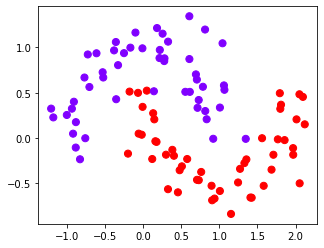

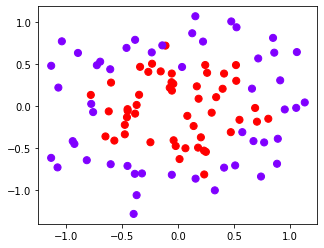

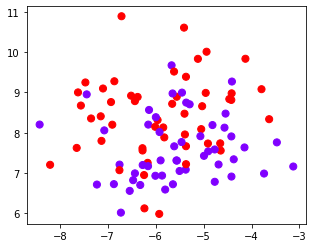

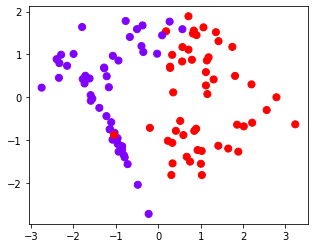

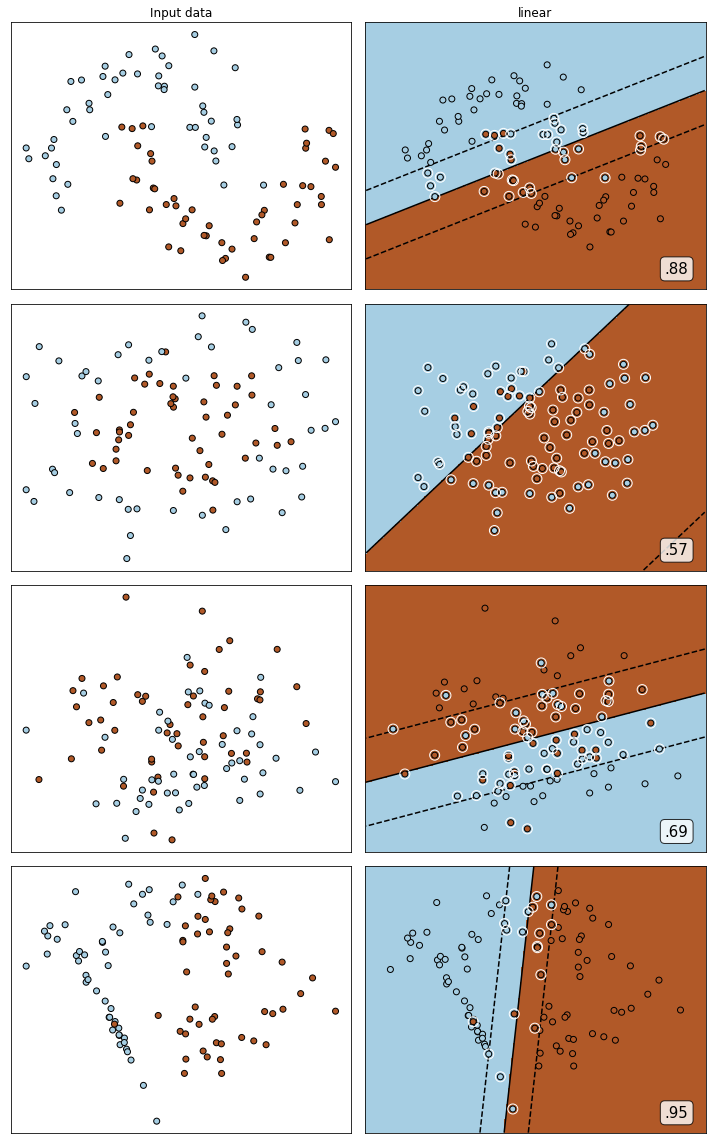

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.datasets import make_circles, make_moons, make_blobs, make_classification

n_samples = 100

datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_blobs(n_samples=n_samples, centers=2, random_state=5),
    make_classification(n_samples=n_samples, n_features=2,
                        n_informative=2, n_redundant=0, random_state=5)
]

Kernel = ["linear"]

# 四个数据集分别是什么样子呢？
for X, Y in datasets:
    plt.figure(figsize=(5, 4))
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap="rainbow")

nrows = len(datasets)
ncols = len(Kernel) + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 16))

# 第一层循环：在不同的数据集中循环
for ds_cnt, (X, Y) in enumerate(datasets):

    # 在图像中的第一列，放置原数据的分布
    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10,
               cmap=plt.cm.Paired, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())

    # 第二层循环：在不同的核函数中循环
    # 从图像的第二列开始，一个个填充分类结果
    for est_idx, kernel in enumerate(Kernel):

        # 定义子图位置
        ax = axes[ds_cnt, est_idx + 1]

        # 建模
        clf = svm.SVC(kernel=kernel, gamma=2).fit(X, Y)
        score = clf.score(X, Y)

        # 绘制图像本身分布的散点图
        ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10,
                   cmap=plt.cm.Paired, edgecolors='k')
        # 绘制支持向量
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                   facecolors='none', zorder=10, edgecolors='white')

        # 绘制决策边界
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

        # np.mgrid，合并了我们之前使用的np.linspace和np.meshgrid的用法
        # 一次性使用最大值和最小值来生成网格
        # 表示为[起始值：结束值：步长]
        # 如果步长是复数，则其整数部分就是起始值和结束值之间创建的点的数量，并且结束值被包含在内
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        # np.c_，类似于np.vstack的功能
        Z = clf.decision_function(
            np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        # 填充等高线不同区域的颜色
        ax.pcolormesh(XX, YY, Z > 0, shading='auto', cmap=plt.cm.Paired)
        # 绘制等高线
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                   levels=[-1, 0, 1])

        # 设定坐标轴为不显示
        ax.set_xticks(())
        ax.set_yticks(())

        # 将标题放在第一行的顶上
        if ds_cnt == 0:
            ax.set_title(kernel)

        # 为每张图添加分类的分数
        ax.text(0.95, 0.06, ('%.2f' % score).lstrip('0'), size=15, bbox=dict(boxstyle='round', alpha=0.8, facecolor='white')                # 为分数添加一个白色的格子作为底色
                , transform=ax.transAxes  # 确定文字所对应的坐标轴，就是ax子图的坐标轴本身
                , horizontalalignment='right'  # 位于坐标轴的什么方向
                )

plt.tight_layout()
plt.show()

## 二分类SVC中的样本不均衡问题：重要参数class_weight

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

In [4]:
class_1 = 500  # 类别1有500个样本，10：1
class_2 = 50  # 类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]]  # 设定两个类别的中心
clusters_std = [1.5, 0.5]  # 设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

In [5]:
X.shape

(550, 2)

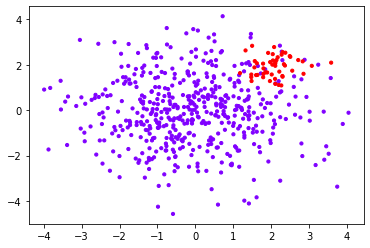

In [6]:
# 看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow", s=10)
plt.show()
# 其中红色点是少数类，紫色点是多数类

In [7]:
# 不设定class_weight
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X, y)

SVC(kernel='linear')

In [8]:
# 设定class_weight
wclf = svm.SVC(kernel='linear', class_weight={1: 10})
wclf.fit(X, y)

SVC(class_weight={1: 10}, kernel='linear')

In [9]:
# 给两个模型分别打分看看，这个分数是accuracy准确度
# 做样本均衡之后，我们的准确率下降了，没有样本均衡的准确率更高
clf.score(X, y)

0.9418181818181818

In [10]:
wclf.score(X, y)

0.9127272727272727

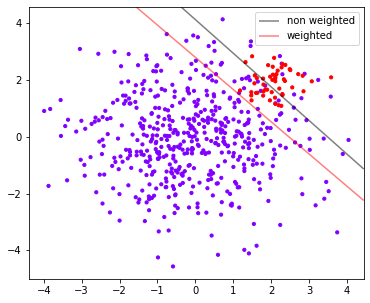

In [11]:
# 首先要有数据分布
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow", s=10)
ax = plt.gca()  # 获取当前的子图，如果不存在，则创建新的子图

# 绘制决策边界的第一步：要有网格
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# 第二步：找出我们的样本点到决策边界的距离
Z_clf = clf.decision_function(xy).reshape(XX.shape)
a = ax.contour(XX, YY, Z_clf, colors='black', levels=[
               0], alpha=0.5, linestyles=['-'])

Z_wclf = wclf.decision_function(xy).reshape(XX.shape)
b = ax.contour(XX, YY, Z_wclf, colors='red', levels=[
               0], alpha=0.5, linestyles=['-'])

# 第三步：画图例
plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],
           loc="upper right")
plt.show()

In [12]:
a.collections  # 调用这个等高线对象中画的所有线，返回一个惰性对象

<a list of 1 mcoll.LineCollection objects>

In [13]:
# 用[*]把它打开试试看
[*a.collections]  # 返回了一个linecollection对象，其实就是我们等高线里所有的线的列表

In [14]:
# 现在我们只有一条线，所以我们可以使用索引0来锁定这个对象
a.collections[0]

In [15]:
# plt.legend([对象列表],[图例列表],loc)
# 只要对象列表和图例列表相对应，就可以显示出图例

In [16]:
#所有判断正确并确实为1的样本 / 所有被判断为1的样本
# 对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum()/(clf.predict(X) == 1).sum()

0.7142857142857143

In [18]:
(y[y == clf.predict(X)] == 1).sum()  # True = 1, False =1 #真实值等于预测值的全部点

30

In [19]:
# 对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum()/(wclf.predict(X) == 1).sum()

0.5102040816326531

In [20]:
#所有predict为1的点 / 全部为1的点的比例
# 对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum()/(y == 1).sum()

0.6

In [21]:
# 对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum()/(y == 1).sum()

1.0

In [22]:
# 所有被正确预测为0的样本 / 所有的0样本
# 对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 0).sum()/(y == 0).sum()

0.976

In [23]:
# 对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 0).sum()/(y == 0).sum()

0.904